In [1]:
import sys as _sys
import warnings as _wrn
import numpy as _nmp
import numpy.random as _rnd
import matplotlib.pyplot as _plt
import pandas as _pnd

%load_ext autoreload
%autoreload 2
%matplotlib inline

_wrn.filterwarnings('always')
_plt.style.use('ggplot')

In [2]:
import eQTLseq as _assoc

Fitting gene 12612 of 12613
540 genes did not converge
/home/dimitris/VENVS/py35mkl/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/dimitris/VENVS/py35mkl/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


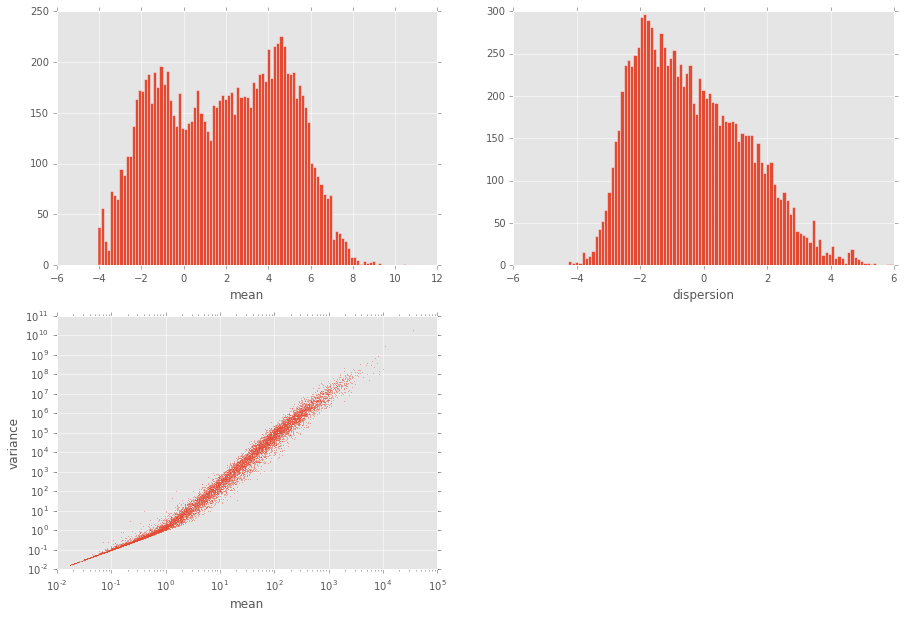

In [3]:
def fcn(fname):
    counts_CEU = _pnd.read_table(fname, index_col=0).values
    counts_CEU = counts_CEU[counts_CEU.sum(1)>0, :]  # remove zero-sum rows
    fit = _assoc.fit_nbinom_model(counts_CEU)
    print('{} genes did not converge'.format((~fit['converged']).sum()), file=_sys.stderr)
    idxs = (fit['converged']) & (_nmp.log(fit['phi']) > -10)
    pars = {'mu': fit['mu'][idxs], 'phi': fit['phi'][idxs]}
    
    return pars

##
pars = fcn('data/montpick_count_table_CEU.txt')

_plt.figure(figsize=(15,10))
_plt.subplot(2,2,1); _plt.hist(_nmp.log(pars['mu']), 100); _plt.xlabel('mean')
_plt.subplot(2,2,2); _plt.hist(_nmp.log(pars['phi']), 100); _plt.xlabel('dispersion');
_plt.subplot(2,2,3); _plt.loglog(pars['mu'], pars['mu'] + pars['mu']**2 / pars['phi'], '.', markersize=0.5); _plt.xlabel('mean'); _plt.ylabel('variance');

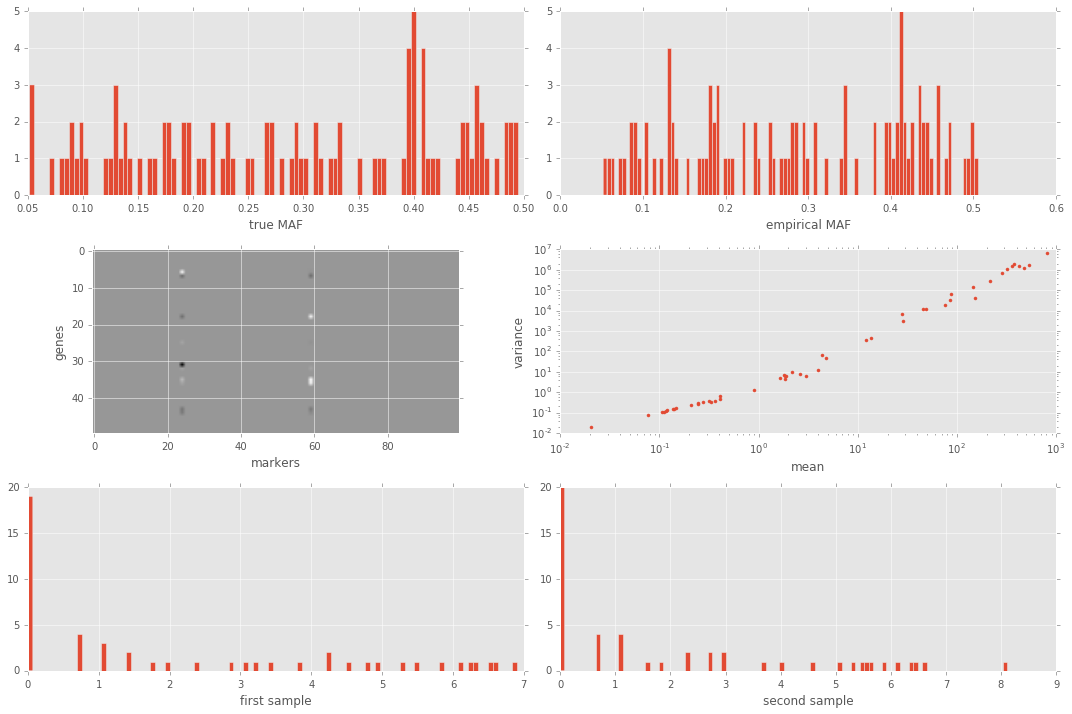

In [4]:
def fcn(n_samples, n_markers, n_markers_causal, n_genes, n_genes_affected, MAF_range):
    data_geno = _assoc.simulate_genotypes(n_samples, n_markers, MAF_range)
    data_pheno = _assoc.simulate_eQTLs_nbinom(data_geno['G'], pars['mu'], pars['phi'], 
                                              n_markers_causal=n_markers_causal, 
                                              n_genes=n_genes, n_genes_affected=n_genes_affected, s2=2)

    _plt.figure(figsize = (15,10));
    _plt.subplot(3,2,1); _plt.hist(data_geno['MAF'], 100); _plt.xlabel('true MAF')
    _plt.subplot(3,2,2); _plt.hist(data_geno['G'].sum(0) / (2 * n_samples), 100); _plt.xlabel('empirical MAF')
    _plt.subplot(3,2,3); _plt.imshow(data_pheno['beta'], cmap=_plt.cm.gray); _plt.xlabel('markers'); _plt.ylabel('genes')
    _plt.subplot(3,2,4); _plt.loglog(data_pheno['mu'], data_pheno['mu'] + data_pheno['mu']**2 / data_pheno['phi'], '.'); _plt.xlabel('mean'); _plt.ylabel('variance');
    _plt.subplot(3,2,5); _plt.hist(_nmp.log(data_pheno['Z'][0,:]+1), 100); _plt.xlabel('first sample');
    _plt.subplot(3,2,6); _plt.hist(_nmp.log(data_pheno['Z'][1,:]+1), 100); _plt.xlabel('second sample');
    _plt.tight_layout()
    
    return data_geno, data_pheno


# def fcn(n_samples, n_markers, n_markers_causal, n_genes, n_genes_affected, MAF_range):
#     counts = _pnd.read_table('data/montpick_count_table.txt', index_col=0).values
#     counts = counts[counts.sum(1)>0, :]  # remove zero-sum rows
#     counts = counts / _assoc.calculate_norm_factors(counts)
    
#     data_geno = _assoc.simulate_genotypes(n_samples, n_markers, MAF_range)
#     data_pheno = _assoc.simulate_eQTLs(counts.T, data_geno['G'], 
#                                        n_markers_causal=n_markers_causal, 
#                                        n_genes=n_genes, n_genes_affected=n_genes_affected, s2=1)

#     _plt.figure(figsize = (15,10));
#     _plt.subplot(3,2,1); _plt.hist(data_geno['MAF'], 100); _plt.xlabel('true MAF')
#     _plt.subplot(3,2,2); _plt.hist(data_geno['G'].sum(0) / (2 * n_samples), 100); _plt.xlabel('empirical MAF')
#     _plt.subplot(3,2,3); _plt.imshow(data_pheno['beta'], cmap=_plt.cm.gray); _plt.xlabel('markers'); _plt.ylabel('genes')
#     _plt.subplot(3,2,5); _plt.hist(_nmp.log(data_pheno['Z'][0,:]+1), 100); _plt.xlabel('first sample');
#     _plt.subplot(3,2,6); _plt.hist(_nmp.log(data_pheno['Z'][1,:]+1), 100); _plt.xlabel('second sample');
#     _plt.tight_layout()
    
#     return data_geno, data_pheno

##
data_geno, data_pheno = fcn(n_samples = 1000,
                            n_markers = 100, n_markers_causal = 2,
                            n_genes = 50, n_genes_affected = 10,
                            MAF_range = [0.05, 0.5])

In [36]:
state, estim = _assoc.run(data_pheno['Z'], data_geno['G'], n_iters = 1000,
                               mdl='Normal', 
                               trans='vst', std=False,
                               norm_factors=None)    

Preparing data...
Iteration 1000 of 1000
Done!


[0.0064666483986810085,
 0.930414454721321,
 0.90000000000000002,
 0.052631578947368418,
 18,
 1,
 4979,
 2]

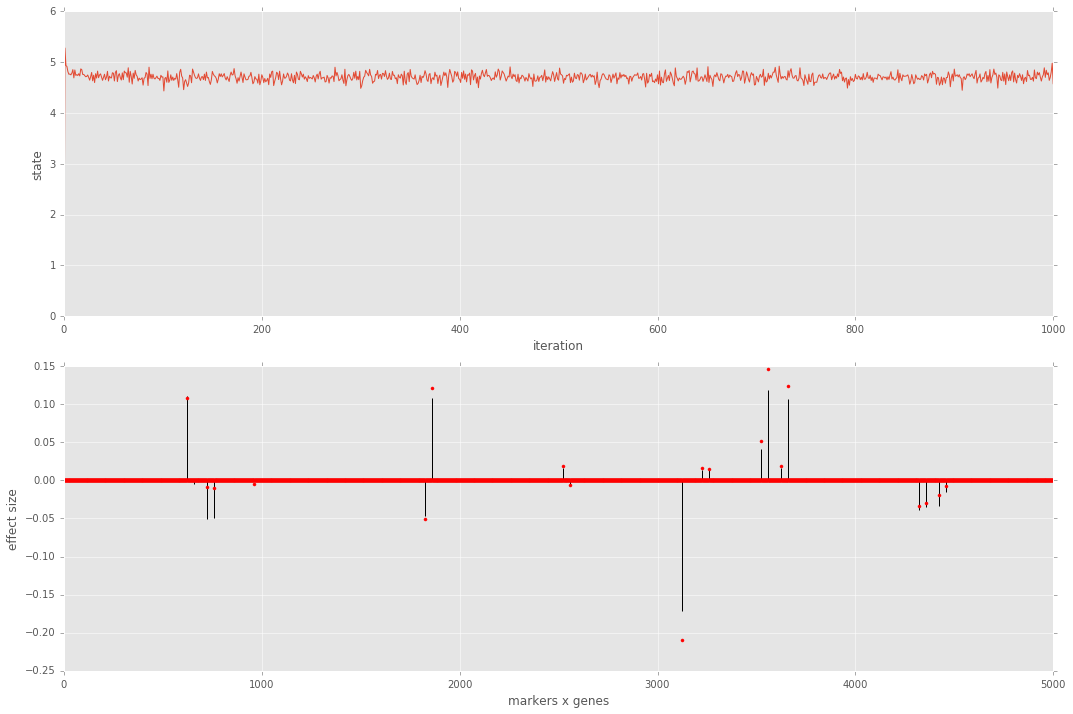

In [37]:
_plt.figure(figsize = (15,10));
_plt.subplot(2,1,1); _plt.plot(state); _plt.xlabel('iteration'); _plt.ylabel('state')

beta_estim = estim['beta'] / _nmp.abs(estim['beta']).sum()
beta_true = data_pheno['beta'] / _nmp.abs(data_pheno['beta']).sum()
n_genes, n_markers = beta_true.shape

_plt.subplot(2,1,2); 
_plt.vlines(range(n_markers * n_genes), 0, beta_true.ravel()); 
_plt.axhline(linestyle='--', color='k');
_plt.plot(beta_estim.ravel(), 'r.'); _plt.xlabel('markers x genes'); _plt.ylabel('effect size')

_plt.tight_layout()

if 'mu' in estim:
    _plt.figure(figsize = (15,10))
    _plt.subplot(2,2,1)
    _plt.plot(_nmp.log(data_pheno['mu']), _nmp.log(estim['mu']), '.'); _plt.ylim(_plt.xlim()); 
    _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
    _plt.xlabel('true log(mu)'); _plt.ylabel('estimated log(mu)')

    if 'phi' in estim:
        var_true = data_pheno['mu'] + data_pheno['phi'] * data_pheno['mu']**2
        var_estim = estim['mu'] + estim['phi'] * estim['mu']**2
        
        _plt.subplot(2,2,2)
        _plt.plot(_nmp.log(var_true), _nmp.log(var_estim), '.'); _plt.ylim(_plt.xlim()); 
        _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
        _plt.xlabel('true log(var)'); _plt.ylabel('estimated log(var)')

_plt.tight_layout()

metrics = _assoc.calculate_metrics(estim['beta'], data_pheno['beta'])
[metrics[_] for _ in ['RSS', 'R2', 'TPR', 'FDR', 'TP', 'FP', 'TN', 'FN']]

In [ ]:
[0.041033272523927924, 0.55845401402547901, 0.84999999999999998, 0.82474226804123707, 17, 80, 4900, 3]
[0.0066980276596156239, 0.92792465613545738, 0.84999999999999998, 0.10526315789473684, 17, 2, 4978, 3]
[0.0064666483986810085, 0.930414454721321, 0.90000000000000002, 0.052631578947368418, 18, 1, 4979, 2]
[0.0013915640380716592, 0.98502582227925561, 0.69999999999999996, 0.0, 14, 0, 4980, 6]
[0.0056134869457415736, 0.93959505358079354, 0.69999999999999996, 0.0, 14, 0, 4980, 6]
[0.0097002299581616398, 0.89561891271142358, 0.75, 0.0, 15, 0, 4980, 5]
[0.012889162838196837, 0.86130382093070779, 0.5, 0.0, 10, 0, 4980, 10]
[0.0038103452954869116, 0.95899808699347455, 0.65000000000000002, 0.0, 13, 0, 4980, 7]

In [30]:
import rpy2.robjects as _R
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [31]:
voom = _R.r('limma::voom')
vst = _R.r('DESeq2::varianceStabilizingTransformation')

In [32]:
counts = _pnd.read_table('data/montpick_count_table.txt', index_col=0).values
counts = counts[counts.sum(1)>0,:]
tmp = vst(counts)
tmp2 = _nmp.asarray(tmp)

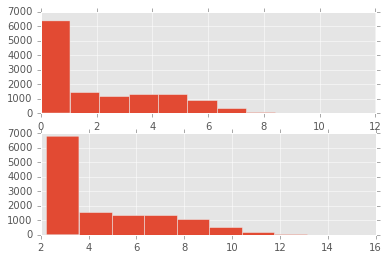

In [33]:
_plt.subplot(2,1,1);_plt.hist(_nmp.log(counts[:,0]+1),10);
_plt.subplot(2,1,2);_plt.hist(tmp2[:,0],10);

In [35]:
data_pheno['Z']

array([[   0,  997,   68, ...,    2,    0,    0],
       [   0,  730,   53, ...,    0,    0,    0],
       [   0, 1202,   51, ...,    2,    0,    0],
       ..., 
       [   0,  859,   23, ...,    5,    0,    0],
       [   0,  486,   33, ...,    0,    0,    0],
       [   0,  656,   78, ...,    0,    0,    1]])

In [ ]:
tmp2